# Hand Gesture Recognition using Transfer Learning
This project showcases the development of a computer vision model for recognizing hand gestures using transfer learning with MobileNetV2. The primary goal is to classify hand gestures efficiently by leveraging the pre-trained feature extraction capabilities of MobileNetV2. By using this transfer learning approach, the project significantly reduces the time and computational resources required to train a deep learning model from scratch.

The workflow presented in this project covers:
- Comprehensive data preprocessing, including normalization and augmentation.
- Model building with a focus on adapting MobileNetV2 for the hand gesture dataset
- Detailed training and evaluation steps to assess the model's performance.
- Exporting the trained model for deployment and future use.

### About the Dataset
The dataset used for this project contains a total of 24,000 images of 20 different hand gestures. For training purposes, each class includes 900 images, and for testing purposes, each class includes 300 images. This dataset is specifically designed for hand gesture recognition tasks, making it an ideal resource for building robust classification models.

**Dataset download**: https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset


### Prerequisites
- Python Version: Python 3.8 or later.
- Required Libraries: TensorFlow, NumPy, Matplotlib, Pandas, and Scikit-learn.
- Basic Knowledge: Familiarity with deep learning concepts and transfer learning principles is helpful for understanding the project.

## 1. Install Dependencies

In [2]:
# Core System Utilities
import os

# Data Handling and Processing
import numpy as np
import pandas as pd
from collections import Counter

# Machine Learning and Model Frameworks
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix

# Image Processing
from PIL import Image

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Handling
In this step, we prepare the image data for training and evaluation using Keras's image_dataset_from_directory. Images are resized to 224×224 to match the input requirements of the MobileNetV2 model.

The training dataset is divided into two parts: 80% for training and 20% for validation. The test dataset is loaded separately to evaluate the model's final performance. Class names are also extracted for visualization purposes, and the sizes of the datasets are printed to ensure proper loading and batching.

This method simplifies data preprocessing while maintaining consistency and scalability for model training.

In [3]:
# Define directories for train and test data
train_dir = '../data/train'
test_dir = '../data/test'

# Dataset variables
batch_size = 32
img_height = 224
img_width = 224

# Functions for loading datasets (directory, resizing, split, batch size) 
# N.B. There are many other arguments that can be used here, especially for colour images

# Load train set with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Save class names from training dataset (for visualisation purposes)
class_names = train_ds.class_names

# Output sizes for verification
print(f"Training dataset size: {len(train_ds)} batches")
print(f"Validation dataset size: {len(val_ds)} batches")
print(f"Test dataset size: {len(test_ds)} batches")


Found 18000 files belonging to 20 classes.
Using 14400 files for training.
Found 18000 files belonging to 20 classes.
Using 3600 files for validation.
Found 6000 files belonging to 20 classes.
Training dataset size: 450 batches
Validation dataset size: 113 batches
Test dataset size: 188 batches


## 2. Inspecting Data
Before applying normalization and augmentation, it is essential to inspect the dataset to ensure its integrity and gain insights into its distribution. This step helps identify potential issues such as corrupt files, imbalanced class distributions, or incorrect formatting, which could negatively impact model training. 
### 2. 1 Data Visualisation
A sample of images from the training and validation datasets was visualized, showcasing examples with their corresponding class labels.

2025-01-07 06:51:48.455805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14400]
	 [[{{node Placeholder/_4}}]]
2025-01-07 06:51:48.456147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14400]
	 [[{{node Placeholder/_4}}]]
2025-01-07 06:51:48.488731: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


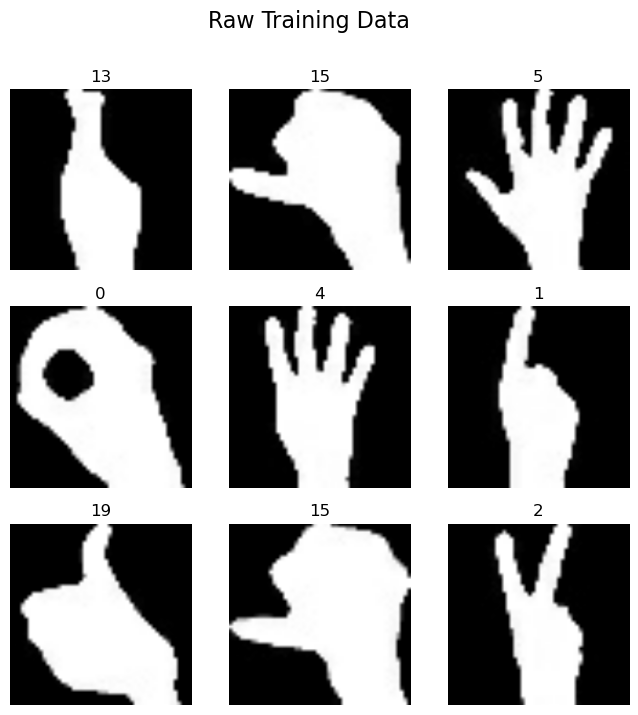

2025-01-07 06:51:48.911729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3600]
	 [[{{node Placeholder/_4}}]]
2025-01-07 06:51:48.911916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3600]
	 [[{{node Placeholder/_0}}]]


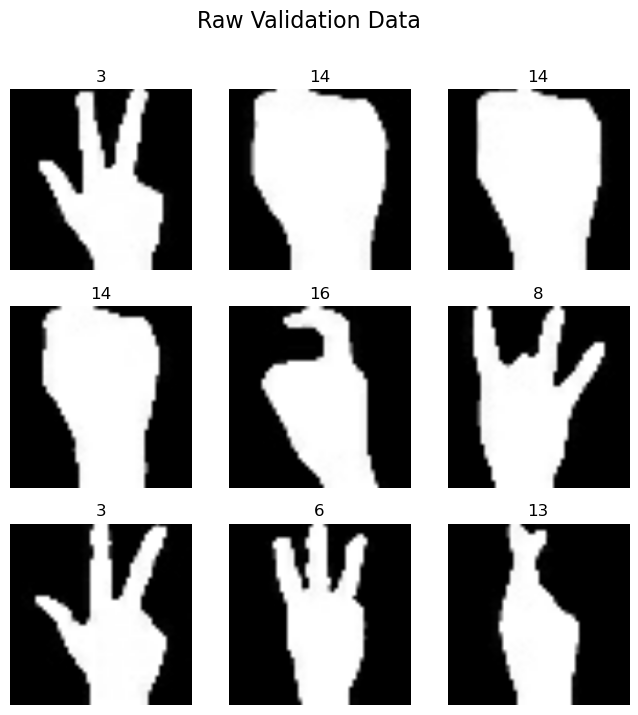

In [4]:
# Define visualization function for raw data
def visualize_raw_dataset(dataset, class_names, title="Sample Images"):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(8, 8))
        for i in range(9):  # Display 9 images
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy().astype("uint8")  # Ensure raw images are displayed
            plt.imshow(image)
            plt.title(class_names[labels[i].numpy()])  # Map label to class name
            plt.axis("off")
        plt.suptitle(title, fontsize=16)
        plt.show()

# Visualize raw datasets
visualize_raw_dataset(train_ds, class_names, title="Raw Training Data")
visualize_raw_dataset(val_ds, class_names, title="Raw Validation Data")

### 2.2 Quality Check
The dataset was scanned for corrupt or unreadable files to ensure that only valid data is passed to the model.
Any errors encountered were logged, and the total number of corrupt files was reported.

In [5]:
# Check for corrupt files
def check_for_corrupt_images(dataset):
    corrupt_count = 0
    for images, labels in dataset:
        try:
            # Attempt to access image data to catch potential errors
            _ = images.numpy()
        except Exception as e:
            print(f"Corrupted image detected: {e}")
            corrupt_count += 1
    print(f"Total corrupted images: {corrupt_count}")

# Run on training dataset
check_for_corrupt_images(train_ds)

2025-01-07 06:51:50.326314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14400]
	 [[{{node Placeholder/_4}}]]
2025-01-07 06:51:50.326742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14400]
	 [[{{node Placeholder/_4}}]]


Total corrupted images: 0


### 2.3 Class Distribution
The number of samples per class was counted in the training dataset to verify that the data is reasonably balanced across categories.
This information is critical for detecting potential class imbalance, which might require additional handling during training.

In [6]:
# Count class occurrences in the training dataset
class_counts = Counter()

for _, labels in train_ds.unbatch():
    class_counts.update([labels.numpy()])  # Wrap the scalar label in a list

print("Class distribution in training dataset:")
for class_index, count in sorted(class_counts.items()):
    print(f"Class {class_index}: {count} samples")


2025-01-07 06:51:53.077420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [14400]
	 [[{{node Placeholder/_4}}]]
2025-01-07 06:51:53.077688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [14400]
	 [[{{node Placeholder/_0}}]]


Class distribution in training dataset:
Class 0: 725 samples
Class 1: 717 samples
Class 2: 726 samples
Class 3: 718 samples
Class 4: 706 samples
Class 5: 713 samples
Class 6: 727 samples
Class 7: 717 samples
Class 8: 719 samples
Class 9: 713 samples
Class 10: 728 samples
Class 11: 713 samples
Class 12: 730 samples
Class 13: 716 samples
Class 14: 717 samples
Class 15: 727 samples
Class 16: 726 samples
Class 17: 728 samples
Class 18: 730 samples
Class 19: 704 samples



## 3 Data Preprocessing
### 3.1 Normalise Data
Normalization is a key step in preparing image data for efficient and consistent training. It scales pixel intensity values to the range [0, 1], ensuring uniformity across inputs and optimizing the model's convergence during training.

A custom normalization layer, implemented using TensorFlow's subclassing API, was used to achieve this. The NormalizeLayer scales input pixel values by dividing them by 255. This modular approach integrates seamlessly into the data pipeline and ensures flexibility for further modifications.

The normalization layer is applied to the training, validation, and test datasets as follows:

In [7]:
# Define Normalisation Layer (Sublassing)
class NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(NormalizeLayer, self).__init__()

    def call(self, inputs):
        return tf.cast(inputs, tf.float32) / 255.0

# Instatiate normalisation layer
normalize_layer = NormalizeLayer()

# Apply normalisation layer
train_ds = train_ds.map(lambda x, y: (normalize_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalize_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalize_layer(x), y))


### 3.2 Data Augmentation
Data augmentation is an essential step to improve the generalizability of the model by artificially increasing the diversity of the training data. It involves applying random transformations to images, helping the model learn to recognize patterns under varying conditions and reducing overfitting.

A custom augmentation layer, implemented using TensorFlow's subclassing API, was created to apply a series of augmentations, including:

- Random Horizontal Flip: Flips images horizontally at random.
- Random Rotation: Rotates images by up to 20% of a full rotation.
- Random Zoom: Zooms into or out of images by up to 10%.

This augmentation layer is applied only to the training dataset to preserve the integrity of validation and test datasets. The implementation is as follows:


In [8]:
# Define Augmentation Layer (Subclassing)
class AugmentationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AugmentationLayer, self).__init__()
        self.augmentations = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.1),
        ])

    def call(self, inputs):
        return self.augmentations(inputs)

augmentation_layer = AugmentationLayer()

# Apply augmentation only to the training dataset
train_ds = train_ds.map(lambda x, y: (augmentation_layer(x), y))

### 3.3 Prefetching

Prefetching is a performance optimization technique that overlaps data preprocessing and model execution. By preloading data while the model is training or evaluating, prefetching reduces idle time and ensures that the next batch of data is ready when needed. This leads to faster training and evaluation by utilizing CPU and GPU resources more efficiently.

In this implementation, TensorFlow's AUTOTUNE is used to dynamically determine the optimal buffer size for prefetching, ensuring optimal performance without manual tuning. Prefetching is applied to the training, validation, and test datasets as follows:

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# Add prefetching to datasets
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## 4. Model Building
### 4.1 Base Model and Custom Layer
In this step, we build the hand gesture classification model by leveraging the pre-trained MobileNetV2 architecture for feature extraction. MobileNetV2, a lightweight convolutional neural network, is utilized with its top layers removed. This approach retains the learned features from the ImageNet dataset while allowing us to customize the architecture for our specific classification task.

**Key Customizations**:

- Freezing the Base Model: The base model is frozen (trainable = False) to prevent updates to its pre-trained weights during training.
- Adding Global Average Pooling: A GlobalAveragePooling2D layer is added to reduce the spatial dimensions of the feature maps while retaining important information.
- Custom Fully Connected Layers:
    - A dense layer with 128 neurons and ReLU activation is added to introduce non-linearity and learn task-specific patterns.
    - A dropout layer with a rate of 0.3 is included to prevent overfitting.
    - A final dense layer with softmax activation outputs the class probabilities for the 20 hand gesture categories.

The model architecture is implemented using TensorFlow's subclassing API, offering flexibility and control over the model's behavior. Below is the core implementation:

In [10]:
class GestureClassificationModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(GestureClassificationModel, self).__init__()
        self.base_model = MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights="imagenet"
        )
        self.base_model.trainable = False  # Freeze base model
        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ])

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=False)
        x = self.global_avg_pooling(x)
        return self.classifier(x)

### 4.2 Compile the Model
After defining the architecture, the model is compiled to configure the training process. The compilation step specifies the optimizer, loss function, and evaluation metrics to be used. For this project, the following configurations were applied:

- Optimizer: The Adam optimizer is chosen for its adaptive learning rate and efficient gradient-based optimization. It performs well across a wide range of tasks, making it a reliable choice for training deep learning models.

- Loss Function: Sparse categorical cross-entropy is used as the loss function since the task involves multi-class classification. This loss function is particularly suitable when class labels are provided as integers instead of one-hot encoded vectors.

- Metrics: Accuracy is used as the evaluation metric to monitor the model's performance during training and validation.

In [11]:
# Number of gesture classes (replace with your actual number of classes)
num_classes = len(class_names)

# Instantiate the model
model = GestureClassificationModel(num_classes)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

## 5. Training the Model
### 5.1 Training Pipeline
The model is trained using the fit method, which processes the data in mini-batches and updates the weights over multiple iterations (epochs). The training dataset (train_ds) is used for learning, while the validation dataset (val_ds) monitors performance during training.

**Key steps include**:

- Batch Processing: Data is divided into mini-batches for efficient training.
- Epochs: Training runs for 5 iterations over the entire dataset.
- Performance Tracking: Training and validation accuracy and loss are tracked after each epoch to monitor progress.

In [12]:
# Train the model
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=5  # Adjust the number of epochs as needed
)

Epoch 1/5


2025-01-07 06:52:17.974865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]
2025-01-07 06:52:17.975328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype resource
	 [[{{node Placeholder/_20}}]]


: 

### 5.2 Monitoring Performance
The model's training and validation performance are monitored using accuracy and loss curves plotted over the training epochs. These visualizations provide insights into the model's learning behavior and help identify potential issues, such as overfitting or underfitting.
**Accuracy Plo**t:

- Both training and validation accuracy improve steadily during the initial epochs.
- Validation accuracy closely follows training accuracy, indicating that the model generalizes well to unseen data.

**Loss Plot**:

- Training and validation loss decrease consistently over the epochs, reflecting effective learning.
- The gap between training and validation loss remains minimal, suggesting no significant overfitting.

By monitoring these metrics, we ensure that the model is learning effectively and can take corrective action if issues like overfitting or stagnation are observed. The smooth convergence of both accuracy and loss curves indicates a well-tuned training process.

## 6. Model Evaluation
### 6.1 Evaluate model on test set
The model's performance is evaluated on the test dataset using the evaluate method. This calculates:

- Test Accuracy: The percentage of correctly classified samples in the test set.
- Test Loss: The average value of the loss function on the test set.

The evaluation provides a summary of the model's performance after training, confirming its effectiveness on unseen data.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


### 6.2 Confusion Matrix
A confusion matrix is generated to assess the model's performance across all classes. It helps identify:

- Class-level performance.
- Misclassifications and the specific classes the model struggles with.

The confusion matrix is visualized using a heatmap, making it easier to interpret results.

In [ ]:
# Generate predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and titles
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The confusion matrix reveals strong performance for many gesture classes, with correctly classified samples evident along the diagonal. However, misclassifications are observed, particularly between Class 13 and Class 14, as well as Class 6 and Class 8, indicating feature similarities. Additionally, Class 18 shows higher errors, likely due to insufficient data or inherent difficulty in classification.

To improve performance, data augmentation (e.g., rotation, flipping, zooming) can increase diversity, especially for classes with high confusion. Balancing the dataset by adding more samples for underrepresented classes like Class 18 is recommended. Refining feature extraction and exploring more complex or fine-tuned models may also enhance differentiation between similar gestures. Finally, analyzing misclassified samples can provide actionable insights to improve preprocessing and training.

Overall, targeted improvements in data and model design will help reduce misclassifications and boost overall accuracy.

### 6.3 Prediction Visualisation
Predictions are visualized by comparing the true labels with the model's predictions. This step helps in verifying whether the model is making accurate predictions for individual samples.Images from the test dataset are displayed with their true labels and predicted labels, providing insights into the model's classification ability.

In [ ]:
 import matplotlib.pyplot as plt

# Denormalize function
def denormalize_image(image):
    return (image * 255).numpy().astype("uint8")  # Scale back to 0–255 and convert to uint8

# Function to visualize predictions
def visualize_predictions(dataset, class_names, model, num_images=9):
    predictions = []
    plt.figure(figsize=(5, 5))

    # Iterate through one batch of the dataset
    for images, labels in dataset.take(1):  # Take one batch
        predictions = model(images, training=False)  # Get predictions for the batch
        predicted_classes = tf.argmax(predictions, axis=1)

        # Visualize up to `num_images` images
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(denormalize_image(images[i]))  # Denormalize before displaying
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[predicted_classes[i].numpy()]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function
visualize_predictions(test_ds, class_names, model)


### 6.4 Failure Classes
Misclassified samples are analyzed to identify patterns in the errors. This step helps pinpoint areas for improvement, such as:

- Ambiguous gestures that are hard to classify.
- Insufficient data for certain classes.

A panel of misclassified images is created to visualize these failure cases along with their true and predicted labels.

In [ ]:
import matplotlib.pyplot as plt

# Denormalize function
def denormalize_image(image):
    return (image * 255).numpy().astype("uint8")  # Scale back to 0–255 and convert to uint8

# Visualize a 2x2 panel of misclassified samples
def visualize_misclassified_panel(dataset, model, class_names):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Collect misclassified samples
    for images, labels in dataset:
        predictions = model(images, training=False)
        predicted_classes = tf.argmax(predictions, axis=1)
        labels = tf.cast(labels, dtype=tf.int64)

        for i in range(len(images)):
            if predicted_classes[i] != labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i].numpy())
                misclassified_predictions.append(predicted_classes[i].numpy())

            # Stop after collecting 4 misclassified samples
            if len(misclassified_images) == 4:
                break
        if len(misclassified_images) == 4:
            break

    # Create a 2x2 panel
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(denormalize_image(misclassified_images[i]))
        true_label = class_names[misclassified_labels[i]]
        pred_label = class_names[misclassified_predictions[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function
visualize_misclassified_panel(test_ds, model, class_names)


## 7 Exporting the Model
### 7.1 Saving the Model
Once the model is trained and evaluated, it can be saved for future use. Exporting the model ensures that it can be reused for inference or fine-tuning without needing to retrain it from scratch. The TensorFlow save method is used to export the model in a portable format.

The trained model is saved in the HDF5 format or TensorFlow SavedModel format. This allows for easy deployment or transfer to other environments.

In [ ]:
# Save the model in TensorFlow's SavedModel format
model.export("gesture_classification_model")

### 7.2 Reloading the Model
The saved model can be reloaded using TensorFlow's load_model method to perform inference or further training.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('hand_gesture_model.h5')

## 8. Conclusion
This project demonstrates the complete workflow for building a robust hand gesture recognition model using transfer learning with MobileNetV2. From data handling and preprocessing to model training, evaluation, and analysis, the project highlights key steps in developing an efficient classification system.

The model performed well overall, achieving high accuracy on the test dataset, but certain classes showed notable misclassifications due to feature similarities or underrepresented data. By addressing these challenges through targeted improvements, such as data augmentation, class balancing, and model optimization, the system can achieve even greater accuracy and reliability.

This workflow not only provides a solid foundation for gesture recognition tasks but also serves as a scalable and adaptable framework for similar computer vision applications. Future enhancements could include experimenting with different architectures, incorporating additional gestures, and deploying the model for real-time use cases. This project successfully showcases the potential of transfer learning in solving practical classification problems.